# Valorant Pro Match Analysis

In [1]:

import numpy as np
import pandas as pd
import sqlite3 as sql
import matplotlib.pyplot as plt
import random
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss, mean_squared_error, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer

import datetime

In [2]:

"""
Dataset:
https://www.kaggle.com/visualize25/valorant-pro-matches-full-data

"""

val_sql = sql.connect('valorant.sqlite')

scoreboard_df = pd.read_sql("""
SELECT
    *
FROM
    Game_Scoreboard
""", val_sql)
rounds_df = pd.read_sql("""
    SELECT
        *
    FROM
        Game_Rounds
""", val_sql)
games_df = pd.read_sql("""
    SELECT
        *
    FROM
        Games
""", val_sql)
matches_df = pd.read_sql("""
    SELECT
        *
    FROM
        Matches
""", val_sql)

val_sql.close()

merge_df = matches_df.merge(games_df)
merge_df = merge_df.merge(rounds_df)
merge_df = merge_df.merge(scoreboard_df)
merge_df['MatchID'] = merge_df['MatchID'].astype(int)

scoreboard_df = scoreboard_df.dropna()
rounds_df = rounds_df.dropna()
games_df = games_df.dropna()
matches_df = matches_df.dropna()
merge_df = merge_df.dropna()


In [3]:
scoreboard_df_prep = scoreboard_df.drop(['PlayerID', 'TeamAbbreviation', 'PlusMinus', 'FirstKills', 'FirstDeaths',
       'FKFD_PlusMinus', 'Num_2Ks', 'Num_3Ks', 'Num_4Ks', 'Num_5Ks', 'OnevOne',
       'OnevTwo', 'OnevThree', 'OnevFour', 'OnevFive', 'Econ', 'Plants',
       'Defuses'], axis=1)

print(scoreboard_df_prep.columns)

scoreboard_df_prep = pd.get_dummies(scoreboard_df_prep, columns=['PlayerName'])
scoreboard_df_prep.head(10)

Index(['GameID', 'PlayerName', 'Agent', 'ACS', 'Kills', 'Deaths', 'Assists',
       'KAST_Percent', 'ADR', 'HS_Percent'],
      dtype='object')


,GameID,Agent,ACS,Kills,Deaths,Assists,KAST_Percent,ADR,HS_Percent,PlayerName_1TaPGoD,...,PlayerName_zeeq,PlayerName_zekken,PlayerName_zeldris,PlayerName_zhan,PlayerName_zill,PlayerName_zizox,PlayerName_zombs,PlayerName_zyad,PlayerName_zyf,PlayerName_Λero
0,60894,jett,313.0,24.0,10.0,3.0,0.65,195.0,0.31,False,...,False,False,False,False,False,False,False,False,False,False
1,60894,chamber,227.0,16.0,10.0,7.0,0.90,161.0,0.16,False,...,False,False,False,False,False,False,False,False,False,False
2,60894,sova,226.0,17.0,9.0,8.0,0.85,148.0,0.27,False,...,False,False,False,False,False,False,False,False,False,False
3,60894,viper,218.0,17.0,12.0,2.0,0.70,141.0,0.19,False,...,False,False,False,False,False,False,False,False,False,False
4,60894,skye,80.0,5.0,13.0,3.0,0.70,55.0,0.22,False,...,False,False,False,False,False,False,False,False,False,False
5,60894,astra,229.0,15.0,16.0,5.0,0.55,155.0,0.31,False,...,False,False,False,False,False,False,False,False,False,False
6,60894,sova,203.0,12.0,14.0,6.0,0.65,151.0,0.22,False,...,False,False,False,False,False,False,False,False,False,False
7,60894,chamber,173.0,12.0,16.0,2.0,0.70,103.0,0.18,False,...,False,False,False,False,False,False,False,False,False,False
8,60894,skye,125.0,9.0,15.0,1.0,0.50,94.0,0.36,False,...,False,False,False,False,False,False,False,False,False,False
9,60894,viper,89.0,6.0,18.0,3.0,0.45,57.0,0.22,False,...,False,False,False,False,False,False,False,False,False,False


# Prediction of Winning Team

# Pre-processing Data

/var/folders/sc/9vkg8j217qnfvz2n5kq71c9h0000gn/T/ipykernel_66371/304462890.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0)


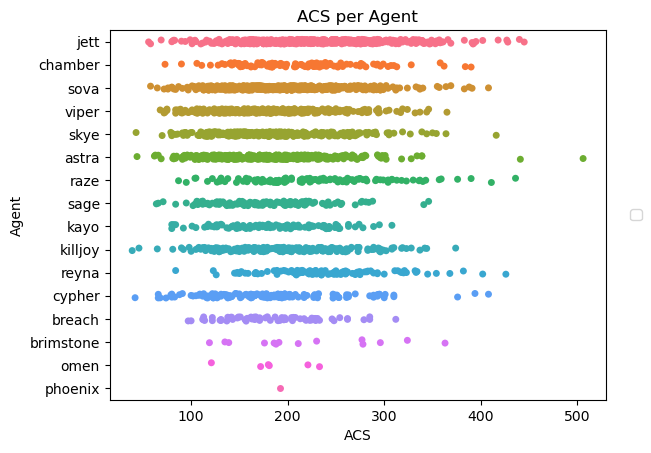

In [4]:
# ACS per agent numerical value (RQ1)
merge_df.groupby('Agent')['ACS'].mean()

# graph for ACS per agent (RQ1)
sns.stripplot(data=merge_df, x="ACS", y="Agent", hue="Agent")

plt.title("ACS per Agent")
plt.xlabel("ACS")
plt.ylabel("Agent")
plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0)

Text(50.77770833333334, 0.5, 'Map')

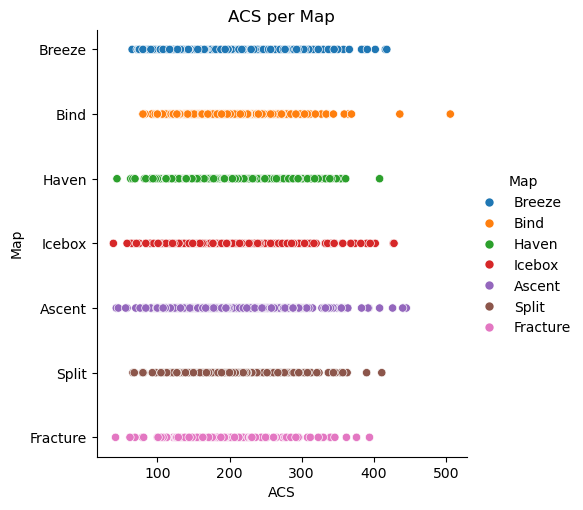

In [5]:
# ACS per map numerical value (RQ1)
merge_df.groupby('Map')['ACS'].mean()

# graph for ACS per map (RQ1)
sns.relplot(data=merge_df, x="ACS", y="Map", hue="Map")

plt.title("ACS per Map")
plt.xlabel("ACS")
plt.ylabel("Map")
     

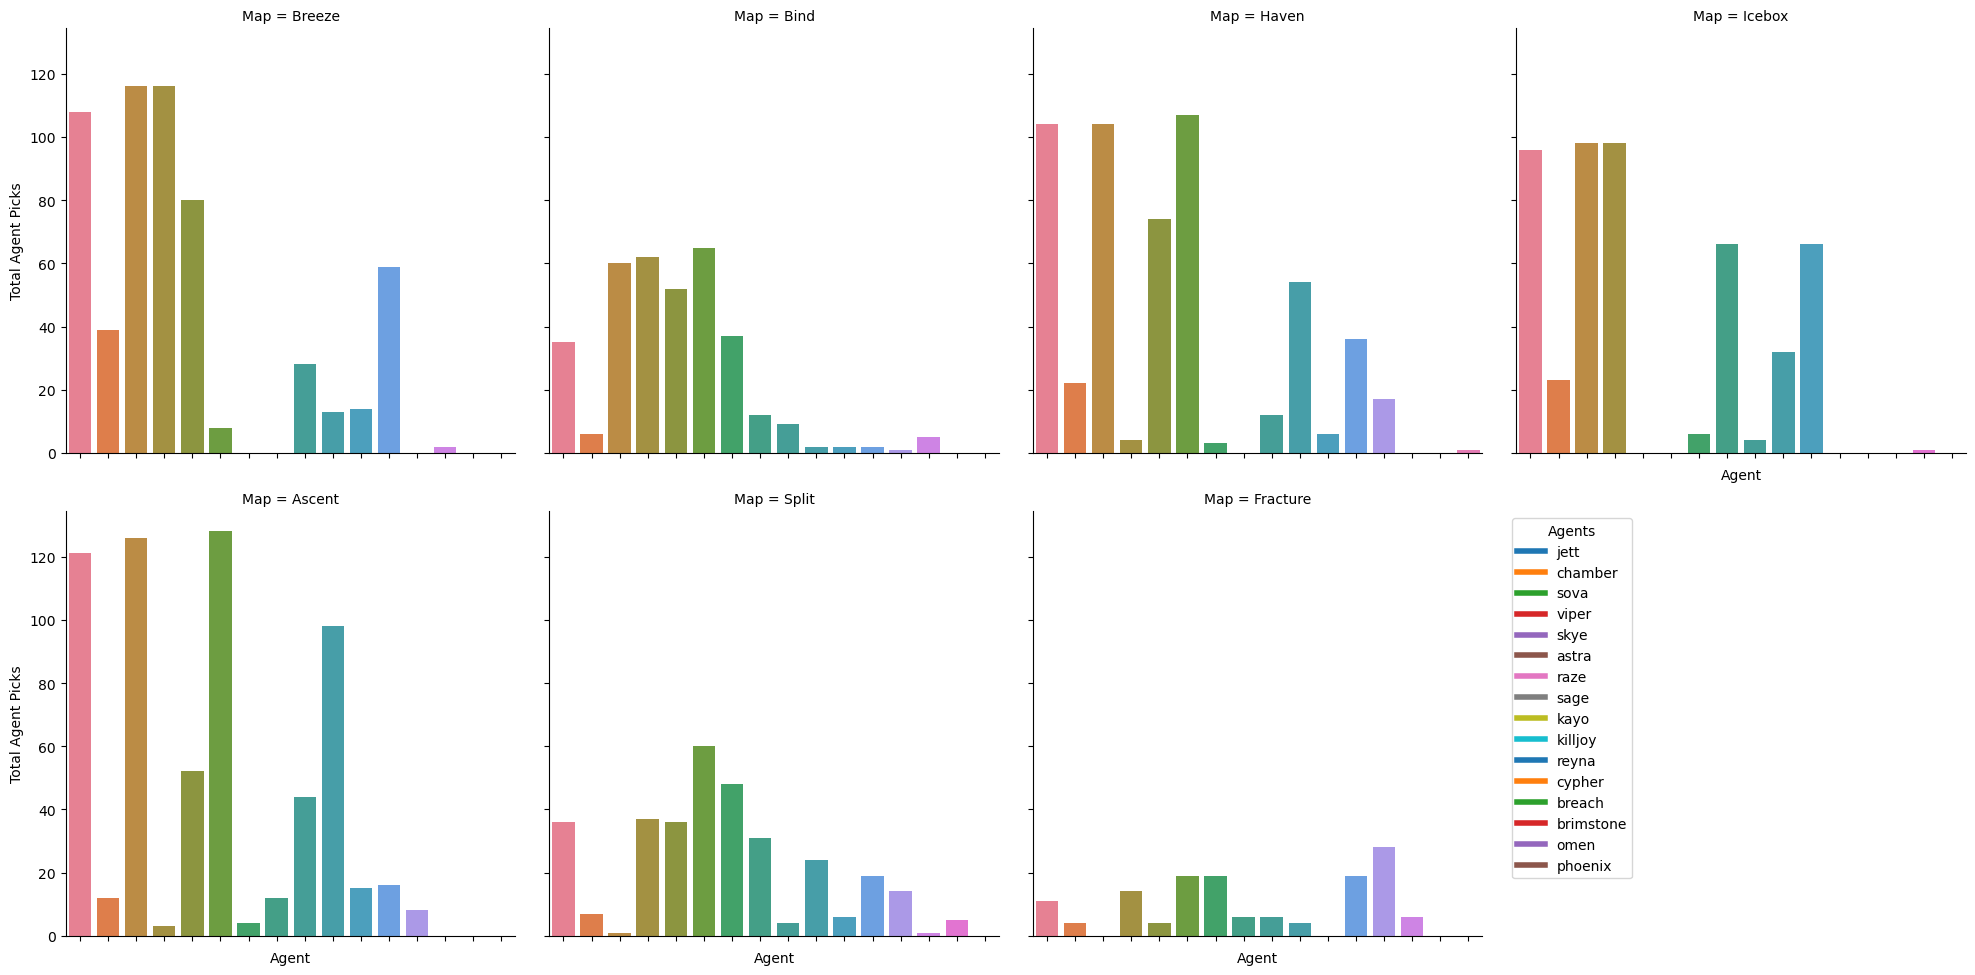

In [6]:

# Create the catplot
g = sns.catplot(
    x="Agent", 
    col="Map", 
    col_wrap=4, 
    data=merge_df, 
    kind="count", 
    hue='Agent', 
    dodge=False
)

# Set axis labels
g.set_axis_labels("Agent", "Total Agent Picks")

# Rotate x-axis labels for better readability
g.set_xticklabels(rotation=65, horizontalalignment='right')

# Manually add a single legend for all subplots
# Access unique agents and their colors
agents = merge_df['Agent'].unique()
handles = [plt.Line2D([0], [0], color=color, lw=4) for color in sns.color_palette(n_colors=len(agents))]
legend_labels = agents
plt.legend(handles, legend_labels, title="Agents", bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()


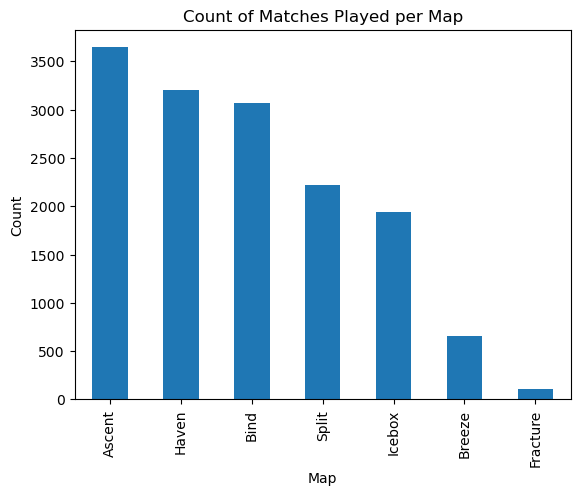

In [7]:
# Count the number of matches played on each map
map_counts = games_df['Map'].value_counts()

# Create a bar chart of the map counts
map_counts.plot.bar()

# Set the title and axis labels
plt.title('Count of Matches Played per Map')
plt.xlabel('Map')
plt.ylabel('Count')

# Show the plot
plt.show()
     

In [8]:
# Merge the two dataframes
merged_df = pd.merge(matches_df[['MatchID', 'Date', 'Team1', 'Team2', 'Team1_MapScore','Team2_MapScore']], games_df[['MatchID', 'GameID', 'Map', 'Winner']], on='MatchID')
# print(merged_df.columns)

In [9]:

merged_df = pd.merge(merged_df[['MatchID', 'Date', 'Team1', 'Team2', 'Team1_MapScore', 'Team2_MapScore', 'GameID', 'Map', 'Winner']], scoreboard_df_prep, on='GameID')

# Drop the MatchID column
merged_df = merged_df.drop('MatchID', axis=1)

# Print the merged dataframe
merged_df.head()

,Date,Team1,Team2,Team1_MapScore,Team2_MapScore,GameID,Map,Winner,Agent,ACS,...,PlayerName_zeeq,PlayerName_zekken,PlayerName_zeldris,PlayerName_zhan,PlayerName_zill,PlayerName_zizox,PlayerName_zombs,PlayerName_zyad,PlayerName_zyf,PlayerName_Λero
0,2022-01-08 15:30:00,Booster Seat Gaming,Pho Real,2,1,60894,Breeze,Booster Seat Gaming,jett,313.0,...,False,False,False,False,False,False,False,False,False,False
1,2022-01-08 15:30:00,Booster Seat Gaming,Pho Real,2,1,60894,Breeze,Booster Seat Gaming,chamber,227.0,...,False,False,False,False,False,False,False,False,False,False
2,2022-01-08 15:30:00,Booster Seat Gaming,Pho Real,2,1,60894,Breeze,Booster Seat Gaming,sova,226.0,...,False,False,False,False,False,False,False,False,False,False
3,2022-01-08 15:30:00,Booster Seat Gaming,Pho Real,2,1,60894,Breeze,Booster Seat Gaming,viper,218.0,...,False,False,False,False,False,False,False,False,False,False
4,2022-01-08 15:30:00,Booster Seat Gaming,Pho Real,2,1,60894,Breeze,Booster Seat Gaming,skye,80.0,...,False,False,False,False,False,False,False,False,False,False


In [10]:
merged_df.shape

(3127, 644)

In [11]:

# Select relevant features
# data = merged_df[['Map', 'Team1', 'Team2', 'Team1_MapScore', 'Team2_MapScore', 'TeamAbbreviation',
#        'Map', 'MapWinner', 'PlayerName', 'Agent', 'ACS', 'Kills', 'Deaths',
#        'Assists', 'KAST_Percent', 'ADR', 'HS_Percent']]

data = merged_df.drop(['GameID', 'Date', 'Team1_MapScore', 'Team2_MapScore'], axis=1)

print(data.columns)

Index(['Team1', 'Team2', 'Map', 'Winner', 'Agent', 'ACS', 'Kills', 'Deaths',
       'Assists', 'KAST_Percent',
       ...
       'PlayerName_zeeq', 'PlayerName_zekken', 'PlayerName_zeldris',
       'PlayerName_zhan', 'PlayerName_zill', 'PlayerName_zizox',
       'PlayerName_zombs', 'PlayerName_zyad', 'PlayerName_zyf',
       'PlayerName_Λero'],
      dtype='object', length=640)


In [12]:

# null_counts = data.isnull().sum()
# null_counts.index.name = 'Column Name'
# null_counts.name = 'Number of Null Values'
# print(null_counts.reset_index())

data = data.dropna()
print(data.shape)
     

(3127, 640)


In [13]:
# One-hot encode categorical features
data = pd.get_dummies(data, columns=['Map', 'Team1', 'Team2', 'Agent'])

In [14]:
scaler = MinMaxScaler()

numerical_cols = [ 'ACS', 'Kills', 'Deaths',
       'Assists', 'KAST_Percent', 'ADR', 'HS_Percent']
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

# pd.set_option('display.max_columns', None)
print(data.shape)
data.head()

(3127, 806)


,Winner,ACS,Kills,Deaths,Assists,KAST_Percent,ADR,HS_Percent,PlayerName_1TaPGoD,PlayerName_1van,...,Agent_kayo,Agent_killjoy,Agent_omen,Agent_phoenix,Agent_raze,Agent_reyna,Agent_sage,Agent_skye,Agent_sova,Agent_viper
0,Booster Seat Gaming,0.586724,0.611111,0.310345,0.136364,0.593023,0.630597,0.424658,False,False,...,False,False,False,False,False,False,False,False,False,False
1,Booster Seat Gaming,0.402570,0.388889,0.310345,0.318182,0.883721,0.503731,0.219178,False,False,...,False,False,False,False,False,False,False,False,False,False
2,Booster Seat Gaming,0.400428,0.416667,0.275862,0.363636,0.825581,0.455224,0.369863,False,False,...,False,False,False,False,False,False,False,False,True,False
3,Booster Seat Gaming,0.383298,0.416667,0.379310,0.090909,0.651163,0.429104,0.260274,False,False,...,False,False,False,False,False,False,False,False,False,True
4,Booster Seat Gaming,0.087794,0.083333,0.413793,0.136364,0.651163,0.108209,0.301370,False,False,...,False,False,False,False,False,False,False,True,False,False


# Training the Model

In [15]:

X = data.drop(['Winner'], axis=1)
y = data['Winner']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit a logistic regression model to the training data
model = RandomForestClassifier(n_estimators = 100)
model.fit(X_train, y_train)

# Evaluate the model on the testing data
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('accuracy score:', accuracy)

accuracy score: 0.9408945686900958


In [16]:
res_df = X_test
res_df['Predicted_Winner'] = y_pred
res_df['True_Winner'] = y_test

res_df['Correct_Prediction'] = (res_df['Predicted_Winner'] == res_df['True_Winner']).astype(int)
res_df[['Predicted_Winner', 'True_Winner', 'Correct_Prediction']].head(10)

,Predicted_Winner,True_Winner,Correct_Prediction
1188,SUPER SQUAD,SUPER SQUAD,1
1134,CoT,CoT,1
2159,Fire Flux Young,Fire Flux Young,1
1467,Zero MarksMen Black,Zero MarksMen Black,1
1072,Akrew,Akrew,1
1702,VIRTUOSO,VIRTUOSO,1
291,Team Valor,Team Valor,1
889,Akrew,Akrew,1
2469,Envy,Envy,1
1614,Built By Gamers Academy,Built By Gamers Academy,1


<Axes: xlabel='Predicted', ylabel='Correct_Prediction'>

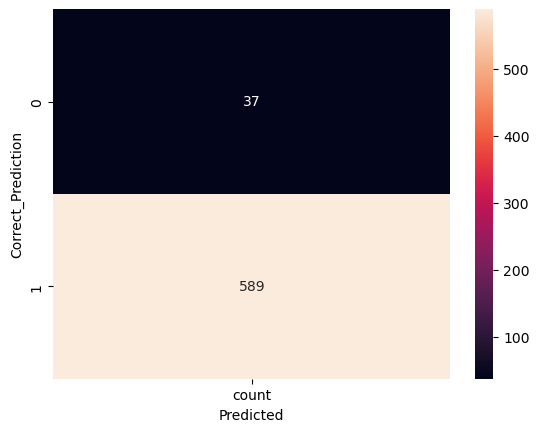

In [17]:
# Create contingency table
ctab = pd.crosstab(index=res_df['Correct_Prediction'], colnames=['Predicted'], columns='count')

# Plot heatmap
sns.heatmap(ctab, annot=True, fmt='d')

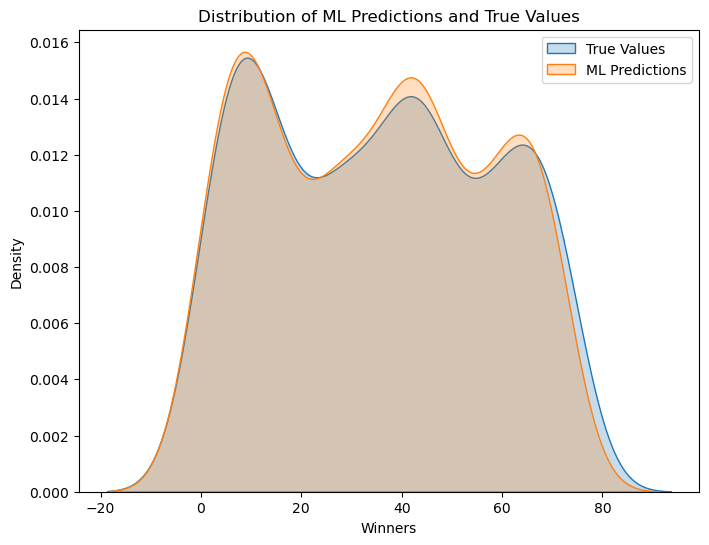

In [18]:

def plot_predictions(res_df):

    res_df['Predicted_Winner'] = res_df['Predicted_Winner'].astype('category')
    res_df['True_Winner'] = res_df['True_Winner'].astype('category')
    res_df['Predicted_Winner'] = res_df['Predicted_Winner'].cat.codes
    res_df['True_Winner'] = res_df['True_Winner'].cat.codes

    plt.figure(figsize=(8,6))
    sns.kdeplot(data=res_df, x=f'True_Winner', label='True Values', fill=True)
    sns.kdeplot(data=res_df, x=f'Predicted_Winner', label='ML Predictions', fill=True)
    plt.xlabel('Winners')
    plt.ylabel('Density')
    plt.title('Distribution of ML Predictions and True Values')
    plt.legend()
    plt.show()

plot_predictions(res_df)

# Prediction from Scoreboard

# Pre-processing Data

In [19]:

player_data = scoreboard_df[['PlayerName', 'ACS', 'Agent', 'ADR',
                'Econ', 'TeamAbbreviation',
                'Kills', 'Deaths', 'Assists']]

player_data.head()     

,PlayerName,ACS,Agent,ADR,Econ,TeamAbbreviation,Kills,Deaths,Assists
0,Reduxx,313.0,jett,195.0,74.0,Boos,24.0,10.0,3.0
1,ChurmZ,227.0,chamber,161.0,67.0,Boos,16.0,10.0,7.0
2,diaamond,226.0,sova,148.0,58.0,Boos,17.0,9.0,8.0
3,Boltzy,218.0,viper,141.0,48.0,Boos,17.0,12.0,2.0
4,Virtyy,80.0,skye,55.0,21.0,Boos,5.0,13.0,3.0


In [20]:

player_data.isnull().sum()
     

PlayerName          0
ACS                 0
Agent               0
ADR                 0
Econ                0
TeamAbbreviation    0
Kills               0
Deaths              0
Assists             0
dtype: int64

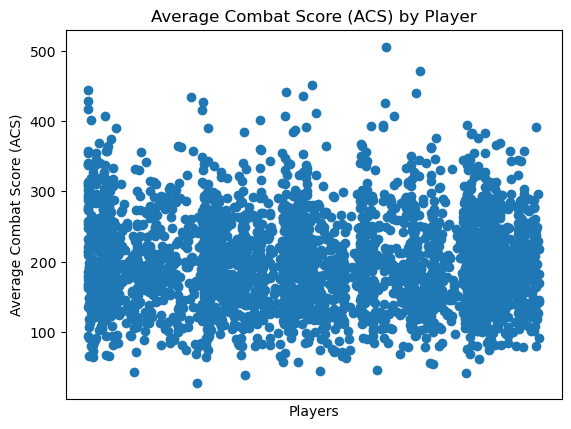

In [21]:

# Create a scatter plot of ACS vs. PlayerName
plt.scatter(player_data['PlayerName'], player_data['ACS'])

# Set the title and axis labels
plt.title('Average Combat Score (ACS) by Player')
plt.xlabel('Players')
plt.ylabel('Average Combat Score (ACS)')

# Remove x-axis labels
plt.xticks([], [])

# Increase the size of the plot
plt.rcParams['figure.figsize'] = [16, 9]

# Show the plot
plt.show()
     

In [22]:
# Preprocess the data
# one hot encode categorical features
player_data = pd.get_dummies(player_data, columns=['Agent', 'TeamAbbreviation'])

# Scale the numerical features using StandardScaler
scaler = MinMaxScaler()
numerical_cols = ['ACS', 'Econ', 'ADR', 'Kills', 'Deaths', 'Assists']
player_data[numerical_cols] = scaler.fit_transform(player_data[numerical_cols])

player_data.head()

,PlayerName,ACS,ADR,Econ,Kills,Deaths,Assists,Agent_astra,Agent_breach,Agent_brimstone,...,TeamAbbreviation_XSET,TeamAbbreviation_YFP,TeamAbbreviation_ZMM.B,TeamAbbreviation_Zeni,TeamAbbreviation_cism,TeamAbbreviation_ex-FB,TeamAbbreviation_ex-L,TeamAbbreviation_ex-S,TeamAbbreviation_same,TeamAbbreviation_waff
0,Reduxx,0.596234,0.637363,0.356383,0.621622,0.310345,0.136364,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,ChurmZ,0.416318,0.512821,0.319149,0.405405,0.310345,0.318182,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,diaamond,0.414226,0.465201,0.271277,0.432432,0.275862,0.363636,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,Boltzy,0.397490,0.439560,0.218085,0.432432,0.379310,0.090909,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,Virtyy,0.108787,0.124542,0.074468,0.108108,0.413793,0.136364,False,False,False,...,False,False,False,False,False,False,False,False,False,False


# Training the Model

In [23]:

X = player_data.drop(['PlayerName'], axis=1)
y = player_data['PlayerName']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
model = RandomForestClassifier(n_estimators = 100)
# model = DecisionTreeClassifier()
model.fit(X_train, y_train)

test_pred = model.predict(X_test)


print("The Training accuracy of the model is {:.2f}".format(model.score(X_train, y_train)))
print("The Testing accuracy of the model is {:.2f}".format(model.score(X_test, y_test)))

res_df = X_test
res_df['Predicted_PlayerName'] = test_pred
res_df['True_PlayerName'] = y_test
res_df = res_df.sort_values(by='ACS', axis=0, ascending=False)
res_df[['Predicted_PlayerName', 'True_PlayerName']].head(10)

The Training accuracy of the model is 1.00
The Testing accuracy of the model is 0.63


,Predicted_PlayerName,True_PlayerName
1532,Reduxx,Reduxx
790,mada,bdog
2110,NamGoku,NamGoku
4904,keznit,Mazino
5764,Derke,Derke
410,flippy,PapiChulo
1842,wubby,Malice
70,Neon,Neon
450,Akashi,Lok1
1652,Reduxx,Reduxx


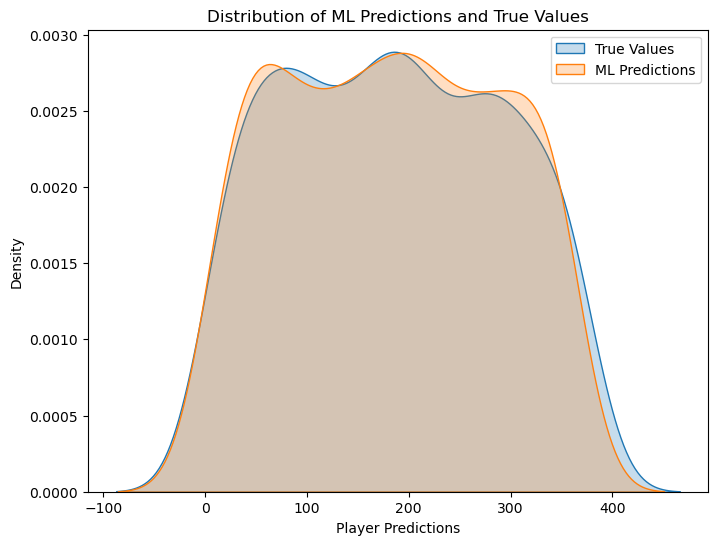

In [25]:
def plot_predictions(res_df):

    res_df['Predicted_PlayerName'] = res_df['Predicted_PlayerName'].astype('category')
    res_df['True_PlayerName'] = res_df['True_PlayerName'].astype('category')
    res_df['Predicted_PlayerName'] = res_df['Predicted_PlayerName'].cat.codes
    res_df['True_PlayerName'] = res_df['True_PlayerName'].cat.codes

    plt.figure(figsize=(8,6))
    sns.kdeplot(data=res_df, x=f'True_PlayerName', label='True Values', fill=True)
    sns.kdeplot(data=res_df, x=f'Predicted_PlayerName', label='ML Predictions', fill=True)
    plt.xlabel('Player Predictions')
    plt.ylabel('Density')
    plt.title('Distribution of ML Predictions and True Values')
    plt.legend()
    plt.show()

plot_predictions(res_df)

# Match Prediction from Team Stats

# Pre-processing Data

In [26]:
%%capture
def team_df(df, stat, players):
  
    df_list = []
    for name in players:
        mask = (df['PlayerName'] == name)
        roster = df[mask]
        roster = roster[['PlayerName', stat]]                           # take corresponding player stats
        roster.rename(columns={stat: f'{name}_{stat}'}, inplace=True)   # rename stats after player name
        df_list.append(roster)

    team = pd.DataFrame()

    for i in range(len(df_list)):

        if i == 0:
            team = df_list[i]
            
        else:
            team = team.merge(df_list[i], how='outer')

    team = team.fillna(0)
    team = pd.get_dummies(team)
    team[stat] = 0

    for name in players:
        team[stat] += team[f'{name}_{stat}']

    return team
     

In [27]:
team = team_df(merge_df, stat='ACS',
                 players=['bdog', 's0m', "TenZ", 'Reduxx', 'ChurmZ'])

team.head()

,bdog_ACS,s0m_ACS,TenZ_ACS,Reduxx_ACS,ChurmZ_ACS,PlayerName_ChurmZ,PlayerName_Reduxx,PlayerName_TenZ,PlayerName_bdog,ACS
0,0.0,0.0,0.0,0.0,227.0,True,False,False,False,227.0
1,0.0,0.0,0.0,0.0,148.0,True,False,False,False,148.0
2,0.0,0.0,0.0,0.0,192.0,True,False,False,False,192.0
3,0.0,0.0,0.0,0.0,304.0,True,False,False,False,304.0
4,0.0,0.0,0.0,0.0,140.0,True,False,False,False,140.0


In [28]:

team.shape
     

(71, 10)

In [29]:
def team_stat_predict(df, stat='ACS', players=['bdog', 's0m', "TenZ", 'Reduxx', 'ChurmZ']):

    team = team_df(df, stat, players)

    # scaler = StandardScaler()
    # numerical_cols = ['bdog_ACS', 's0m_ACS', 'TenZ_ACS', 'Reduxx_ACS', 'ChurmZ_ACS']
    # team[numerical_cols] = scaler.fit_transform(team[numerical_cols])

    model = DecisionTreeRegressor()
    # model = RandomForestClassifier(n_estimators=100)


    X = team.drop([f'{stat}'], axis=1)
    y = team[f'{stat}']

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 0.8, test_size=0.2, random_state=42)

    model.fit(X_train, y_train)
    test_pred = model.predict(X_test)

    accuracy = model.score(X_test, y_test)

    # print("The Training accuracy of the model is {:.2f}".format(model.score(X_train, y_train)))
    # print("The Testing accuracy of the model is {:.2f}".format(model.score(X_test, y_test)))

    res_df = X_test
    res_df[f'ML_{stat}'] = test_pred
    res_df[f'True_{stat}'] = y_test
    # RMS = mean_squared_error(y_test, test_pred)
    average = np.average(test_pred)



    return average, accuracy, res_df

In [30]:

# players = ['Reduxx', 'TenZ', 'MaKo', 'Shao', 'Bdog']
players = ['supA', 's0m', "leaf", 'runi', 'ChurmZ']
stats = 'Kills'

average, accuracy, res = team_stat_predict(merge_df, stats, players)

print('Accuracy: ', accuracy)
print('Average stats: ', average)

res.head()
     

Accuracy:  0.9335260115606936
Average stats:  15.0


,supA_Kills,s0m_Kills,leaf_Kills,runi_Kills,ChurmZ_Kills,PlayerName_ChurmZ,PlayerName_leaf,PlayerName_runi,PlayerName_supA,ML_Kills,True_Kills
39,8.0,0.0,0.0,0.0,0.0,False,False,False,True,10.0,8.0
25,0.0,0.0,23.0,0.0,0.0,False,True,False,False,21.0,23.0
26,0.0,0.0,17.0,0.0,0.0,False,True,False,False,17.0,17.0
43,15.0,0.0,0.0,0.0,0.0,False,False,False,True,14.0,15.0
35,0.0,0.0,0.0,25.0,0.0,False,False,True,False,23.0,25.0


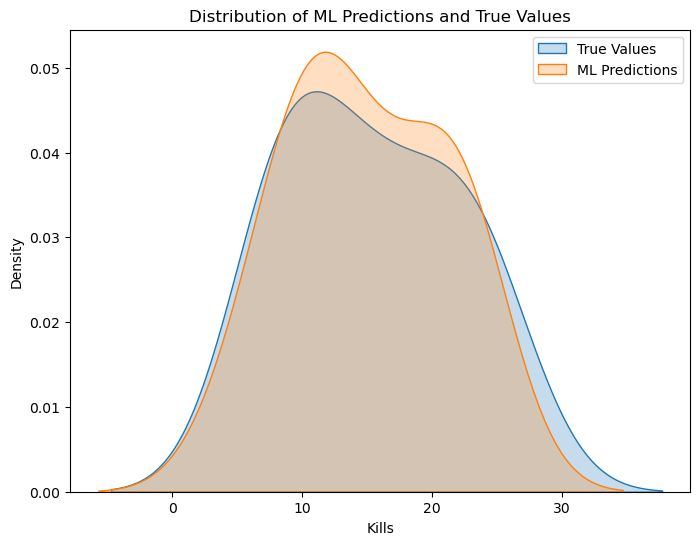

In [31]:

# %%capture
def plot_predictions(res_df, stat):
    plt.figure(figsize=(8,6))
    sns.kdeplot(data=res_df, x=f'True_{stat}', label='True Values', fill=True)
    sns.kdeplot(data=res_df, x=f'ML_{stat}', label='ML Predictions', fill=True)
    plt.xlabel(stat)
    plt.ylabel('Density')
    plt.title('Distribution of ML Predictions and True Values')
    plt.legend()
    plt.show()

plot_predictions(res, stats)

# Predictor Function

In [32]:
def match_predict(df, teamA, teamB, stats):
    
    teamA_score = 0.0
    teamB_score = 0.0

    # map_series = df[df['Map'] != 'TBD']
    map_list = df['Map'].unique().tolist()
    map_list.remove('Fracture')

    map = random.choice(map_list)
    
    print('MAP: ', map)

    for stat in stats:
        tA_stat_avg, accuracy_A, res_df = team_stat_predict(df[df['Map'] == map],
                                            stat, teamA)
        tB_stat_avg, accuracy_B, res_df = team_stat_predict(df[df['Map'] == map],
                                            stat, teamB)
        
        if tA_stat_avg > tB_stat_avg:
            teamA_score += 1
        elif tA_stat_avg < tB_stat_avg:
            teamB_score += 1
        else:
            teamA_score += .5
            teamB_score += .5


    if teamA_score > teamB_score:
        print(f'Team A won in {map}')
        
    elif teamA_score < teamB_score:
        print(f'Team B won in {map}')
        
    else:
        coinflip = np.random.randint(2)
        if coinflip == 0:
            print(f'Team A won in {map} (OT)')
            
        else:
            print(f'Team B won in {map} (OT)')

In [33]:
import warnings
warnings.filterwarnings('ignore')

team1 = ['Reduxx', 'TenZ', 'MaKo', 'Shao', 'Bdog']
team2 = ['supA', 's0m', "leaf", 'runi', 'ChurmZ']
match_predict(merge_df, team1, team2, ['ACS', 'Econ', 'Kills', 'ADR', 'Assists', 'KAST_Percent'])

MAP:  Haven
Team A won in Haven


# Map-wise Agents Recommender

In [34]:
import random

# Step 1: Merge Game_Scoreboard with Games to include the 'Map' field
merged_data = scoreboard_df.merge(games_df[['GameID', 'Map']], on="GameID", how="inner")

# Step 2: Aggregate agent-specific performance metrics for each map
agent_performance = (
    merged_data.groupby(["Map", "Agent"])
    .agg(
        ACS=("ACS", "mean"),
        Kills=("Kills", "mean"),
        ADR=("ADR", "mean"),
        KAST_Percent=("KAST_Percent", "mean"),
        GamesPlayed=("GameID", "count")
    )
    .reset_index()
)


# Step 3: Assign roles to agents
agent_roles = {
    "jett": "Duelist", "reyna": "Duelist", "raze": "Duelist", "yoru": "Duelist", "phoenix": "Duelist",
    "omen": "Controller", "viper": "Controller", "brimstone": "Controller", "astra": "Controller",
    "sova": "Initiator", "skye": "Initiator", "breach": "Initiator", "kayo": "Initiator",
    "sage": "Sentinel", "killjoy": "Sentinel", "cypher": "Sentinel", "chamber": "Sentinel"
}

agent_performance = agent_performance[agent_performance["Agent"].str.strip() != ""]

agent_performance = agent_performance[agent_performance["Map"].str.strip() != "TBD"]

# Convert agent names to lowercase in the dataset
agent_performance["Agent"] = agent_performance["Agent"].str.lower()

# Map roles to agents
agent_performance["Role"] = agent_performance["Agent"].map(agent_roles)

# Filter out agents with unknown roles
unknown_agents = agent_performance[agent_performance["Role"].isna()]["Agent"].unique()
if len(unknown_agents) > 0:
    print(f"The following agents are missing from the role mapping: {list(unknown_agents)}")
agent_performance = agent_performance[agent_performance["Role"].notna()]

# Step 4: Define the function to recommend a balanced team for a given map
def recommend_balanced_team_for_map(map_name, agent_data, weights=None):
    """
    Recommends a balanced team of 5 agents for a given map.
    Composition: 2 Duelists, 1 Controller, 1 Initiator, 1 Sentinel.

    Args:
        map_name (str): The name of the map (e.g., "Ascent", "Bind").
        agent_data (pd.DataFrame): DataFrame containing agent performance metrics.
        weights (dict): Weights for each performance metric. Default values are used if None.

    Returns:
        pd.DataFrame: Recommended team with their roles and performance metrics.
    """
    if weights is None:
        weights = {
            "ACS": 0.5,         # ACS gets the highest weight
            "Kills": 0.2,       # Importance of kills
            "ADR": 0.2,         # Importance of damage per round
            "KAST_Percent": 0.1 # Rounds with contributions
        }
    
    # Filter data for the specified map
    map_data = agent_data[agent_data["Map"] == map_name].copy()
    
    if map_data.empty:
        print(f"No data available for the map: {map_name}")
        return None

    # Normalize metrics to bring them to the same scale
    for metric in weights.keys():
        map_data[f"{metric}_Normalized"] = map_data[metric] / map_data[metric].max()

    # Compute the weighted score for each agent
    map_data["Score"] = sum(
        weights[metric] * map_data[f"{metric}_Normalized"] for metric in weights.keys()
    )

    # Pick the best agents for each role
    team = pd.concat([
        map_data[map_data["Role"] == "Duelist"].nlargest(2, "Score"),  # 2 Duelists
        map_data[map_data["Role"] == "Controller"].nlargest(1, "Score"),  # 1 Controller
        map_data[map_data["Role"] == "Initiator"].nlargest(1, "Score"),  # 1 Initiator
        map_data[map_data["Role"] == "Sentinel"].nlargest(1, "Score")   # 1 Sentinel
    ])

    return team[["Agent", "Role", "Map", "ACS", "Kills", "ADR", "KAST_Percent", "Score"]]

# Step 5: Get a random map from the data
available_maps = agent_performance[agent_performance["Map"].str.strip() != "TBD"]["Map"].unique()

print("Available maps:", available_maps)
random_map = random.choice(available_maps)

# Step 6: Recommend a balanced team for the random map
balanced_team = recommend_balanced_team_for_map(random_map, agent_performance)

if balanced_team is not None and not balanced_team.empty:
    print(f"Recommended team for {random_map}:")
    print(balanced_team)
else:
    print(f"No valid team composition found for {random_map}.")


Available maps: ['Ascent' 'Bind' 'Breeze' 'Fracture' 'Haven' 'Icebox' 'Split']
Recommended team for Icebox:
      Agent        Role     Map         ACS      Kills         ADR  \
69    reyna     Duelist  Icebox  236.857143  16.757143  155.771429   
64     jett     Duelist  Icebox  231.000000  16.274510  147.333333   
72    viper  Controller  Icebox  191.173077  13.375000  129.625000   
65     kayo   Initiator  Icebox  196.750000  15.500000  123.750000   
63  chamber    Sentinel  Icebox  216.000000  16.000000  139.434783   

    KAST_Percent     Score  
69      0.693857  0.996719  
64      0.680980  0.965966  
72      0.689327  0.825713  
65      0.702500  0.857141  
63      0.717391  0.925959  


In [35]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


# Player Role Classfier Function

        FirstKills      Assists      OnevOne     OnevTwo
count  3367.000000  3367.000000  3367.000000  3367.00000
mean      2.055242     5.308880     0.187704     0.09801
std       1.746546     3.278278     0.451896     0.31766
min       0.000000     0.000000     0.000000     0.00000
25%       1.000000     3.000000     0.000000     0.00000
50%       2.000000     5.000000     0.000000     0.00000
75%       3.000000     7.000000     0.000000     0.00000
max      11.000000    22.000000     3.000000     3.00000
Role
All-Rounder      2961
Support           250
Entry Fragger     154
Clutcher            2
Name: count, dtype: int64
Logistic Regression Results:
               precision    recall  f1-score   support

  All-Rounder       1.00      1.00      1.00       615
     Clutcher       1.00      1.00      1.00         2
Entry Fragger       1.00      1.00      1.00       206
      Support       0.99      1.00      1.00       362

     accuracy                           1.00      1185
    mac

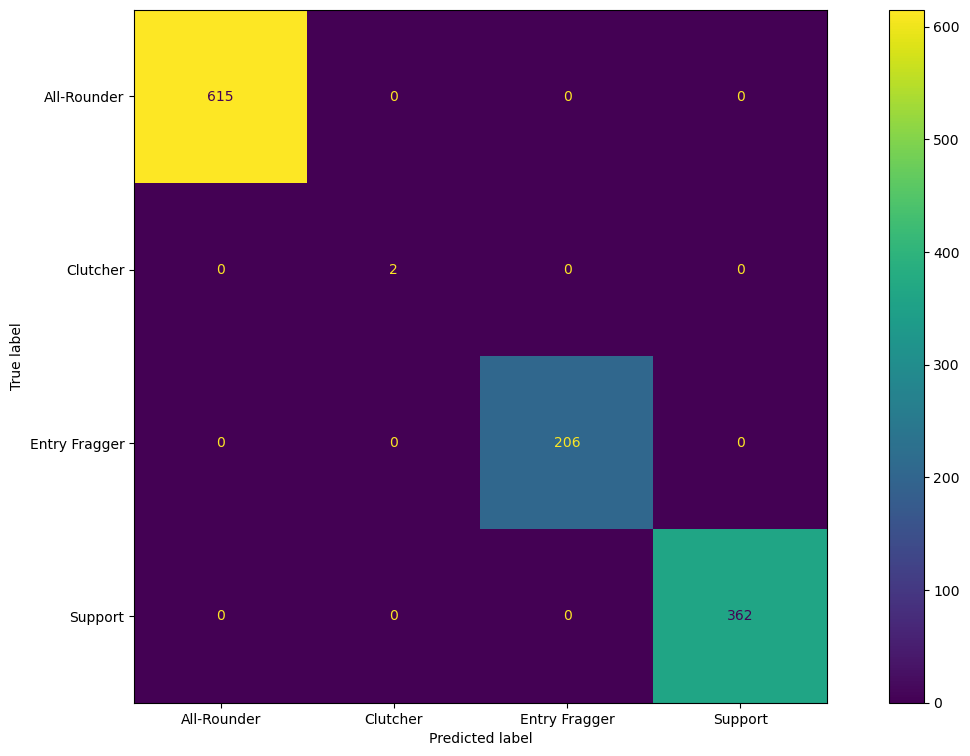

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.utils import resample


# Step 2: Analyze and Define Player Roles
# Print feature distribution for thresholds adjustment
print(scoreboard_df[['FirstKills', 'Assists', 'OnevOne', 'OnevTwo']].describe())

# Adjust thresholds based on dataset analysis
def classify_role(row):
    if row['FirstKills'] > 5:  # Lower threshold for FirstKills
        return 'Entry Fragger'
    elif row['Assists'] > 10:  # Adjust Assists threshold
        return 'Support'
    elif row['OnevOne'] + row['OnevTwo'] > 3:  # Lower clutch threshold
        return 'Clutcher'
    else:
        return 'All-Rounder'

# Add the Role column
scoreboard_df['Role'] = scoreboard_df.apply(classify_role, axis=1)

# Check class distribution
print(scoreboard_df['Role'].value_counts())

# Step 3: Balance the Dataset (Resampling)
# Separate majority and minority classes
all_rounders = scoreboard_df[scoreboard_df['Role'] == 'All-Rounder']
other_roles = scoreboard_df[scoreboard_df['Role'] != 'All-Rounder']

# Upsample minority classes
other_roles_upsampled = resample(
    other_roles,
    replace=True,
    n_samples=len(all_rounders),  # Match the majority class size
    random_state=42
)

# Combine resampled data
balanced_df = pd.concat([all_rounders, other_roles_upsampled])

# Step 4: Feature and Label Selection
features = ['Kills', 'Assists', 'Deaths', 'FirstKills', 'FirstDeaths', 'OnevOne', 'OnevTwo', 'ADR', 'KAST_Percent']
X = balanced_df[features]
y = balanced_df['Role']

# Handle missing values
imputer = SimpleImputer(strategy='mean')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Step 5: Logistic Regression Model
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced')
log_reg.fit(X_train, y_train)

# Predictions and Evaluation
y_pred_log = log_reg.predict(X_test)
print("Logistic Regression Results:")
print(classification_report(y_test, y_pred_log, target_names=label_encoder.classes_))

# Step 6: Random Forest Classifier (Alternative Model)
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
print("Random Forest Results:")
print(classification_report(y_test, y_pred_rf, target_names=label_encoder.classes_))

# Step 7: Neural Network Model
scaler = StandardScaler()
X_scaled_train = scaler.fit_transform(X_train)
X_scaled_test = scaler.transform(X_test)

# Build Neural Network
model = Sequential([
    Dense(64, input_dim=X_scaled_train.shape[1], activation='relu'),
    Dense(32, activation='relu'),
    Dense(len(label_encoder.classes_), activation='softmax')  # Output layer
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train Neural Network
history = model.fit(X_scaled_train, y_train, epochs=50, batch_size=16, validation_split=0.2, verbose=1)

# Evaluate Neural Network
loss, accuracy = model.evaluate(X_scaled_test, y_test, verbose=0)
print(f"Neural Network Accuracy: {accuracy:.2f}")

# Confusion Matrix for Neural Network
y_pred_nn = model.predict(X_scaled_test).argmax(axis=1)
cm = confusion_matrix(y_test, y_pred_nn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot()



In [37]:

# Step 8: Classify a Specific Player by Name
def classify_player(player_name):
    # Fetch player stats
    player_stats = scoreboard_df[scoreboard_df['PlayerName'] == player_name]
    if player_stats.empty:
        print(f"No data found for player: {player_name}")
        return
    
    # Extract and preprocess features
    player_features = player_stats[features]
    player_features = pd.DataFrame(imputer.transform(player_features), columns=features)
    
    # Scale features for neural network
    player_features_scaled = scaler.transform(player_features)
    
    # Predict with logistic regression
    log_reg_prediction = label_encoder.inverse_transform(log_reg.predict(player_features))[0]
    
    # Predict with neural network
    nn_prediction = label_encoder.inverse_transform(model.predict(player_features_scaled).argmax(axis=1))[0]
    
    print(f"Player: {player_name}")
    print(f"Logistic Regression Prediction: {log_reg_prediction}")
    print(f"Neural Network Prediction: {nn_prediction}")

# Example: Classify a specific player
classify_player("Boaster") 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Player: Boaster
Logistic Regression Prediction: Support
Neural Network Prediction: Support


# Map-wise Player Agent Recommender

In [40]:

# Step 1: Merge Data with Map Information
# Merge Game_Scoreboard with Games to add the Map field
merged_data = pd.merge(scoreboard_df, games_df[['GameID', 'Map']], on='GameID', how='inner')

# Step 2: Drop Records Where Agent is Empty
merged_data = merged_data[merged_data['Agent'] != '']

# Step 3: Aggregate Data
# Aggregate player performance by Agent and Map
agent_stats = merged_data.groupby(['PlayerName', 'Agent', 'Map']).agg({
    'ACS': 'mean',
    'Kills': 'sum',
    'Deaths': 'sum',
    'ADR': 'mean'
}).reset_index()

# Add map-specific win rates for agents (optional)
map_agent_winrate = merged_data.groupby(['Map', 'Agent']).agg({
    'ACS': 'mean',
    'Kills': 'mean',
    'Deaths': 'mean',
}).reset_index()

# Merge agent stats with map-specific win rates
agent_performance = pd.merge(agent_stats, map_agent_winrate[['Map', 'Agent']], on=['Map', 'Agent'], how='left')

# Simplify the dataset
agent_performance = agent_performance[['PlayerName', 'Agent', 'Map', 'ACS', 'Kills', 'Deaths', 'ADR']]

# Step 4: Feature Engineering
# Features and target
features = ['ACS', 'Kills', 'Deaths', 'ADR']
X = agent_performance[features]
y = agent_performance['Agent']

# Encode target (Agent)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Ensure that all classes have at least 2 instances to avoid stratification errors
unique_classes, class_counts = np.unique(y_encoded, return_counts=True)
valid_classes = unique_classes[class_counts > 1]
valid_indices = np.isin(y_encoded, valid_classes)
X = X[valid_indices]
y_encoded = y_encoded[valid_indices]

# Step 5: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Step 6: Train the Model
# Random Forest Classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Step 7: Evaluate the Model
y_pred = model.predict(X_test)

# Ensure correct target names by using only the unique labels in y_test
unique_labels = np.unique(y_test)
target_names = label_encoder.inverse_transform(unique_labels)

print("Agent Recommendation System Results:")
print(classification_report(y_test, y_pred, target_names=target_names))

# Step 8: Recommend an Agent
def recommend_agent(player_name, map_name, trained_model):
    # Filter data for the player and map
    player_data = agent_performance[(agent_performance['PlayerName'] == player_name) & 
                                    (agent_performance['Map'] == map_name)]
    if player_data.empty:
        print(f"No data available for player: {player_name} on map: {map_name}")
        return
    
    # Use the model to predict the best agent
    player_features = player_data[features]
    predicted_agent_index = trained_model.predict(player_features)
    predicted_agent = label_encoder.inverse_transform(predicted_agent_index)
    
    print(f"Recommended Agent for {player_name} on {map_name}: {predicted_agent[0]}")
    return predicted_agent[0]

# Example Usage
recommend_agent("TenZ", "Haven", model)



Agent Recommendation System Results:
              precision    recall  f1-score   support

       astra       0.16      0.19      0.17        57
      breach       0.00      0.00      0.00        15
   brimstone       0.00      0.00      0.00         2
     chamber       0.00      0.00      0.00        15
      cypher       0.00      0.00      0.00        22
        jett       0.30      0.47      0.37        73
        kayo       0.00      0.00      0.00        15
     killjoy       0.00      0.00      0.00        36
        omen       0.00      0.00      0.00         1
        raze       0.29      0.11      0.15        19
       reyna       0.00      0.00      0.00        16
        sage       0.00      0.00      0.00        19
        skye       0.04      0.05      0.05        41
        sova       0.20      0.25      0.23        72
       viper       0.07      0.07      0.07        45

    accuracy                           0.16       448
   macro avg       0.07      0.08      0.07

'jett'

# Map-wise Team Winning Predictor

In [39]:
# Step 2: Merge Data with Map Information
# Merge Game_Scoreboard with Games to add the Map field
merged_data = pd.merge(scoreboard_df, games_df[['GameID', 'Map', 'Team1', 'Team2']], on='GameID', how='inner')

# Step 3: Drop Records Where Agent is Empty
merged_data = merged_data[merged_data['Agent'] != '']

# Step 4: Aggregate Data
# Aggregate team performance by Map and TeamAbbreviation
team_stats = merged_data.groupby(['Map', 'TeamAbbreviation']).agg({
    'Kills': 'sum',
    'Deaths': 'sum',
    'ACS': 'mean',
    'ADR': 'mean'
}).reset_index()

# Calculate additional metrics
team_stats['KD_Ratio'] = team_stats['Kills'] / team_stats['Deaths']

# Aggregate map-specific win rates
map_winrate = games_df.groupby(['Map', 'Team1']).agg({
    'Team1_TotalRounds': 'sum',
    'Team2_TotalRounds': 'sum'
}).reset_index()
map_winrate['WinRate'] = map_winrate['Team1_TotalRounds'] / (
    map_winrate['Team1_TotalRounds'] + map_winrate['Team2_TotalRounds']
)

# Join team stats with map win rates
team_features = pd.merge(team_stats, map_winrate[['Map', 'Team1', 'WinRate']], 
                          left_on=['Map', 'TeamAbbreviation'], right_on=['Map', 'Team1'], how='left')

# Create dataset for match prediction
match_data = pd.merge(games_df, team_features, left_on=['Map', 'Team1'], right_on=['Map', 'TeamAbbreviation'], how='left')
match_data = pd.merge(match_data, team_features, left_on=['Map', 'Team2'], right_on=['Map', 'TeamAbbreviation'], how='left', suffixes=('_Team1', '_Team2'))

# Select features
features = [
    'ACS_Team1', 'ADR_Team1', 'KD_Ratio_Team1', 'WinRate_Team1',
    'ACS_Team2', 'ADR_Team2', 'KD_Ratio_Team2', 'WinRate_Team2'
]
X = match_data[features]
y = (match_data['Team1_TotalRounds'] > match_data['Team2_TotalRounds']).astype(int)  # 1 if Team1 wins, 0 otherwise

# Handle missing values
X.fillna(X.mean(), inplace=True)

# Step 5: Balance Dataset
class_0 = match_data[match_data['Team1_TotalRounds'] <= match_data['Team2_TotalRounds']]
class_1 = match_data[match_data['Team1_TotalRounds'] > match_data['Team2_TotalRounds']]

# Undersample majority class
class_1_downsampled = resample(class_1, replace=False, n_samples=len(class_0), random_state=42)

# Combine balanced data
balanced_match_data = pd.concat([class_0, class_1_downsampled])

# Define new features and labels
X = balanced_match_data[features]
y = (balanced_match_data['Team1_TotalRounds'] > balanced_match_data['Team2_TotalRounds']).astype(int)

# Step 6: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 7: Train the Model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Step 8: Evaluate the Model
y_pred = model.predict(X_test)
print("Match Winner Predictor Results:")
print(classification_report(y_test, y_pred))

# Step 9: Predict Match Winner
def predict_winner(team1, team2, map_name, trained_model):
    available_teams = team_features['TeamAbbreviation'].unique()
    if team1 not in available_teams or team2 not in available_teams:
        print(f"Error: One or both teams ({team1}, {team2}) not found in dataset.")
        return
    
    team1_data = team_features[(team_features['TeamAbbreviation'] == team1) & (team_features['Map'] == map_name)]
    team2_data = team_features[(team_features['TeamAbbreviation'] == team2) & (team_features['Map'] == map_name)]
    
    if team1_data.empty or team2_data.empty:
        print(f"No match history available for {team1} or {team2} on {map_name}.")
        return

    match_features = pd.DataFrame([{
        'ACS_Team1': team1_data['ACS'].values[0],
        'ADR_Team1': team1_data['ADR'].values[0],
        'KD_Ratio_Team1': team1_data['KD_Ratio'].values[0],
        'WinRate_Team1': team1_data['WinRate'].values[0],
        'ACS_Team2': team2_data['ACS'].values[0],
        'ADR_Team2': team2_data['ADR'].values[0],
        'KD_Ratio_Team2': team2_data['KD_Ratio'].values[0],
        'WinRate_Team2': team2_data['WinRate'].values[0]
    }])

    prediction = trained_model.predict(match_features)
    winner = team1 if prediction[0] == 1 else team2
    print(f"Predicted Winner in match between {team1} and {team2} on {map_name}: {winner}")
    return winner

# Example Usage
predict_winner("SEN", "100T", "Haven", model)


Match Winner Predictor Results:
              precision    recall  f1-score   support

           0       0.69      0.01      0.03       684
           1       0.50      0.99      0.67       684

    accuracy                           0.50      1368
   macro avg       0.60      0.50      0.35      1368
weighted avg       0.60      0.50      0.35      1368

Predicted Winner in match between SEN and 100T on Haven: SEN


'SEN'